# Using MIR to help create a Wall of Sound Composition

Wall of Sound is a production and sound design technique based on layering sounds to create a fuller and thicker sound. You can find a deeper explanation of this technique <a href="https://en.wikipedia.org/wiki/Wall_of_Sound">here</a>.

I am creating a wall of sound with a collection of audio samples that I selected because I think that will sound good together. An extensive collection of samples was analyzed previously, and for this exercise, I choose the ones that are in the same tonality.

When layering sounds I have observed that there is a tendency of accumulating energy around 1kHz and 2Kh, and this creates an uncomfortable sound. This notebook proposes a method to help the sound designer decide how to avoid this accumulation of energy either by eliminating some sounds or distribute them across the spectrum to have the same energy across the whole spectrum and create a pleasant sound.

To distribute this sounds, I have found that the Spectral Centroid calculation helps in finding the sound's position in the spectrum. 

This notebook helps to analyze a set of audio files, find their Spectral Centroid, and to classify them by setting each sound into one of three categories: low, mid, high.

Joaquin Jimenez Sauma (SMC17)

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import IPython
import pandas as pd
from essentia import *
from essentia.standard import *
from collections import defaultdict

### Next cell reads files in `path` and loads them to compute the spectral centroid.

Selected files are in the path specified in the next cell, where I am loading them into `c` variable. This example looks for file with a `.wav` extension, but you can change it and use any kind of audio file format. This cell ends with a list of centroids for each file in the dictionary `centroidList`.

In [2]:
path = '../../data/wavs/'

w = Windowing()
spec = Spectrum()
centroid = Centroid(range=22050)

centroidList = {}
for file in os.listdir(path):
    if file.endswith(".wav"):
        audio = MonoLoader(filename= path + file, sampleRate=44100)()
        c = []
        for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
            c.append(centroid(spec(w(frame))))
        centroidList[file] = np.array(c)

### Plotting some sounds to be aware of their spectral centroid.

You can use the next cell to selec the files you want to visualize.

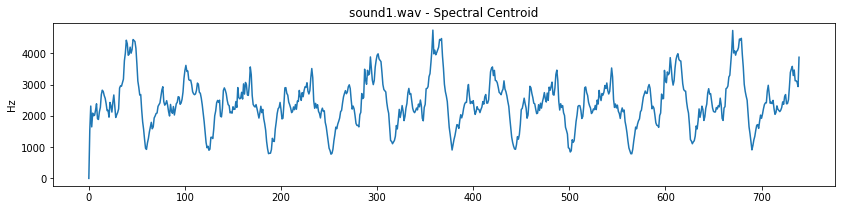

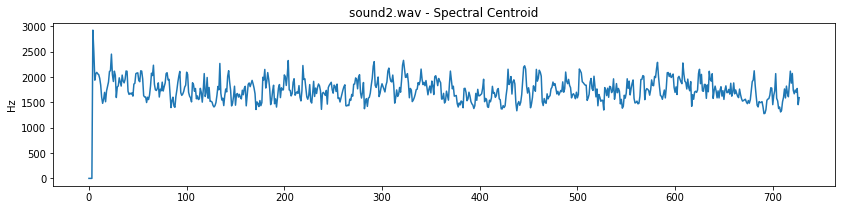

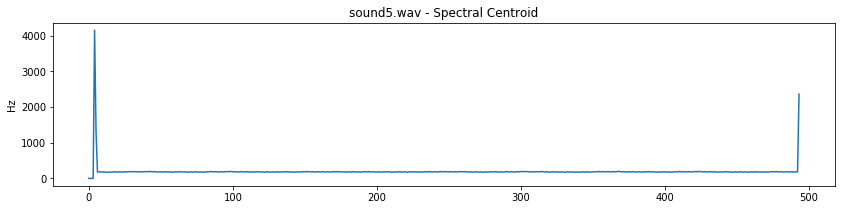

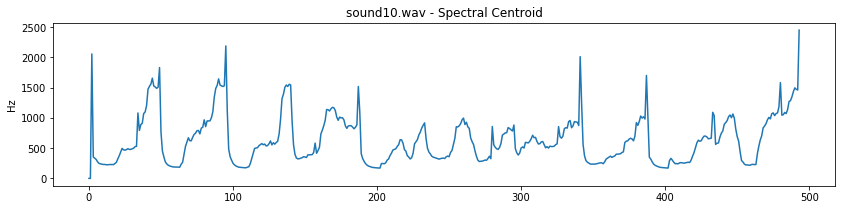

In [3]:
sounds = ['sound1.wav', 'sound2.wav', 'sound5.wav', 'sound10.wav']
for sound in sounds:
    fig= plt.figure(figsize=(14,3))
    plt.plot(centroidList[sound])
    plt.ylabel('Hz')
    plt.title(sound + ' - Spectral Centroid')
    plt.show()
    IPython.display.Audio(path + sound)

### Next cell computes the median of spectral centroid for each file

This cell computes the median of each entry in `centroidList`, or for each file. I have found that median is more accurate for this calculation. Also it applies to this kind of files because this are a few seconds long.

At the end of the cell each value (median of spectral centroid) in `centroidList` is plotted to help classify the files. Thresholds are set to 300Hz and 2000Hz to separate in three bands, but you can change it accordingly.

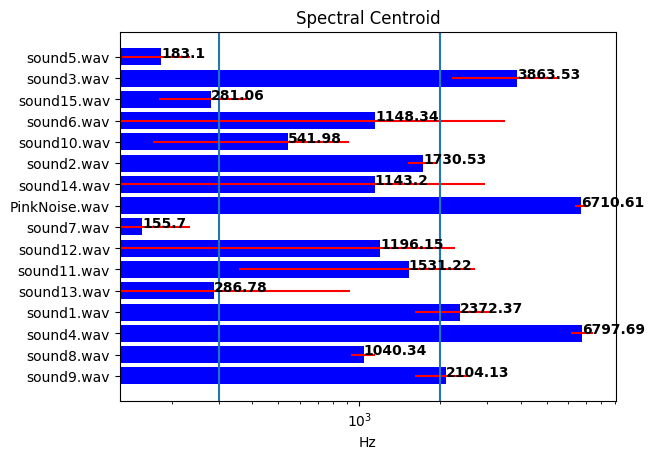

In [4]:
keys = []
means = []
stds = []
band = []
mean = 0
for key, value in centroidList.items(): # For each file
    #print(key + ': std=' + str(np.std(value[5:-5])) + ' mean=' + str(np.median(value[5:-5])))
    keys.append(key)
    stds.append(np.std(value[5:-5]))
    mean = (np.median(value[5:-5]))
    means.append(mean)
    if mean <= 300:
        band.append('low') 
    else:
        if mean > 2000:
            band.append('high')
        else:
            band.append('mid')

plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(np.arange(len(keys)), means, xerr=stds, align='center',
        color='blue', ecolor='red')
ax.set_xscale('log')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys)
ax.invert_yaxis()
ax.set_xlabel('Hz')
ax.set_title('Spectral Centroid')
plt.axvline(x=300)
plt.axvline(x=2000)
for i, v in enumerate(means):
    ax.text(v, i , str(round(v,2)), color='black', fontweight='bold')
plt.show()


### Next cell assigns band classification based on human judgement

This cell shows the classification I have set by listening the files. I wouldn't call it ground truth, since this is perceptual opinion. In fact, I would call Spectral Centroid the real ground truth, since it is calculated from real data and not based on human judgement.

In [10]:
humanClass = ['mid', 'mid', 'high', 'high', 'mid', 'low', 'mid', 'low', 'mid', 'high', 'mid', 'low', 'high', 'low', 'mid']

### Now let's compute a confusion matrix to compare calculated vs human classification

Next two cells compute and show a confusion matrix to show differences between human  and spectral centroid classification.

In [11]:
y_actu = pd.Series(humanClass)
y_pred = pd.Series(band)
df_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

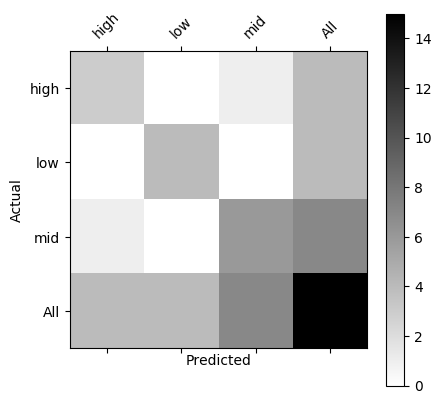

In [12]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

## Conclusions

Results and confusion matrix show a correlation between human judgement and Spectral Centroid calculation. Errors can be found where Spectral Centroid is near the threshold, which is confusing for a human.